<a href="https://colab.research.google.com/github/kenchin138/DA-and-DS-Projects/blob/main/Google_Play_Store_App_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Environment

In [1]:
import pandas as pd
import plotly.express as px
import os
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
pwd = os.getcwd()

# Loading Dataset

The dataset contains 10,841 entries and 13 features in total.

In [3]:
data = pd.read_csv(pwd + '/googleplaystore.csv', encoding='unicode_escape')

In [ ]:
data.sample(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Current_Ver,Android_Ver
2736,Candy Crush Saga,GAME,4.40,22428456,74,"500,000,000+",Free,0,Everyone,Casual,5-Jul-18,1.129.0.2,4.1 and up
2201,Shadow Fight 2,GAME,4.60,10981850,88,"100,000,000+",Free,0,Everyone 10+,Action,2-Jul-18,1.9.38,3.0 and up
8038,Blood Donor,MEDICAL,4.20,4476,20,"500,000+",Free,0,Everyone,Medical,31-Jul-18,1.6.2,4.1 and up
104,Who,COMMUNICATION,4.30,2451093,NaN,"100,000,000+",Free,0,Teen,Communication,3-Aug-18,Varies with device,Varies with device
10269,MegaNDS (NDS Emulator),GAME,3.40,2218,11,"500,000+",Free,0,Everyone,Arcade,18-Oct-17,2,4.0 and up
8253,Stickman and Axe,GAME,4.40,69,2.8,"50,000+",Free,0,Teen,Action,25-Nov-17,1,4.0.3 and up
9311,EGW Writings 2,BOOKS_AND_REFERENCE,4.70,6547,16,"100,000+",Free,0,Everyone,Books & Reference,8-Dec-17,4.0.3,4.0.3 and up
6172,EP Gem Hunter,GAME,4.60,79,31,"1,000+",Free,0,Everyone 10+,Action,17-Jan-16,1.1.0,2.3 and up
126,True Contact - Real Caller ID,COMMUNICATION,4.10,32283,NaN,"1,000,000+",Free,0,Everyone,Communication,26-Jul-18,Varies with device,Varies with device
3164,Where's My Water?,FAMILY,4.70,188740,69,"1,000,000+",Paid,1.99,Everyone,Puzzle;Brain Games,5-Jul-18,1.16.0,4.2 and up


In [ ]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content_Rating     object
Genres             object
Last_Updated       object
Current_Ver        object
Android_Ver        object
dtype: object

In [ ]:
data.shape

(10841, 13)

# Data Preprocessing

## Dropping Unused Columns
Since `Last_Updated`, `Current_Ver`, and `Android_Ver` are not relevant to the analysis, they will be dropped.

In [4]:
data_cleaned = data.copy()
data_cleaned.drop(['Last_Updated', 'Current_Ver', 'Android_Ver'], axis=1, inplace=True)

##Formatting Values

In [5]:
data_cleaned['Category'].replace({'_':' ', 'AND':'&'}, regex=True, inplace=True)
data_cleaned['Category'] = data_cleaned['Category'].str.title()
data_cleaned['Installs'].replace({'\+':'', ',':''}, regex=True, inplace=True)
data_cleaned.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
0,Floor Plan Creator,Art & Design,4.10,36639,NaN,5000000,Free,0,Everyone,Art & Design
1,Textgram - write on photos,Art & Design,4.40,295221,NaN,10000000,Free,0,Everyone,Art & Design
2,Used Cars and Trucks for Sale,Auto & Vehicles,4.60,17057,NaN,1000000,Free,0,Everyone,Auto & Vehicles
3,Ulysse Speedometer,Auto & Vehicles,4.30,40211,NaN,5000000,Free,0,Everyone,Auto & Vehicles
4,REPUVE,Auto & Vehicles,3.90,356,NaN,100000,Free,0,Everyone,Auto & Vehicles


## Checking Inconsistencies

`Rating` is the only feature that has a numerical data type while `Reviews`, `Size`, `Installs`, and `Price` should also be numerical. These features may contain strings that should be removed.

`Rating` also has an outlier of 19 when ratings should only go up to 5.

`Type` should have only two categories, `free` and `paid`. However, there are three categories.

Further investigation reveals that a single row with missing data in `Category` caused its values to shift to the left. Removing this row resolves the above errors.

Although the data type and `Rating` outliers are resolved, the maximum value of `Price` is still very high compared to its average price of around 1 dollar. The most expensive apps are populated by 'I am rich' and its alternatives, which are apps designed to charge high prices for minimal features. They are also submitted to the Play Store under various categories without regard to the actual content of the apps. Prices will be limited to apps under \$100 to filter out these apps and avoid skewing the data.

The data also contains duplicates. The total count for `App` does not match the unique count. Duplicates with the highest reviews are considered to be the most up to date and will be kept.

In [ ]:
data_cleaned.describe()

,Rating
count,"9,367.00"
mean,4.19
std,0.54
min,1.00
25%,4.00
50%,4.30
75%,4.50
max,19.00


In [ ]:
data_cleaned.describe(include='object')

,App,Category,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
count,10841,10841,10841,9146,10841,10840,10841,10840,10841
unique,9660,34,6002,461,21,3,93,6,120
top,ROBLOX,Family,0,11,1000000,Free,0,Everyone,Tools
freq,9,1972,596,198,1579,10039,10040,8714,842


In [ ]:
data_cleaned.loc[data_cleaned['Reviews'] == '3.0M']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
10840,Life Made WI-Fi Touchscreen Photo Frame,NaN,19.00,3.0M,"1,000",Free,0,Everyone,NaN,11-Feb-18


In [6]:
data_cleaned.drop(data_cleaned.index[10840], inplace=True)

In [7]:
data_cleaned['Reviews'] = data_cleaned['Reviews'].astype(int)
data_cleaned['Price'] = data_cleaned['Price'].astype(float)
data_cleaned['Installs'] = data_cleaned['Installs'].astype(int)
data_cleaned['Size'] = data_cleaned['Size'].astype(float)
data_cleaned.describe()

,Rating,Reviews,Size,Installs,Price
count,"9,366.00","10,840.00","9,145.00","10,840.00","10,840.00"
mean,4.19,"444,152.90",21.52,"15,464,338.88",1.03
std,0.52,"2,927,760.60",22.59,"85,029,361.40",15.95
min,1.00,0.00,0.01,0.00,0.00
25%,4.00,38.00,4.90,"1,000.00",0.00
50%,4.30,"2,094.00",13.00,"100,000.00",0.00
75%,4.50,"54,775.50",30.00,"5,000,000.00",0.00
max,5.00,"78,158,306.00",100.00,"1,000,000,000.00",400.00


In [ ]:
data_cleaned.describe(include='object')

,App,Category,Type,Content_Rating,Genres
count,10840,10840,10839,10840,10840
unique,9659,33,2,6,119
top,ROBLOX,Family,Free,Everyone,Tools
freq,9,1972,10039,8714,842


In [82]:
data_cleaned.sort_values('Price', ascending=False).head(20)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
3029,I'm Rich - Trump Edition,Lifestyle,3.60,275,7.30,10000,Paid,400.00,Everyone,Lifestyle
6354,I am Rich,Finance,4.30,180,3.80,5000,Paid,399.99,Everyone,Finance
10650,most expensive app (H),Family,4.30,6,1.50,100,Paid,399.99,Everyone,Entertainment
8314,I Am Rich Pro,Family,4.40,201,2.70,5000,Paid,399.99,Everyone,Entertainment
2403,I am Rich Plus,Family,4.00,856,8.70,10000,Paid,399.99,Everyone,Entertainment
8315,I am rich (Most expensive app),Finance,4.10,129,2.70,1000,Paid,399.99,Teen,Finance
5077,I'm Rich/Eu sou Rico/?????? ??????/????????????,Lifestyle,NaN,0,40.00,0,Paid,399.99,Everyone,Lifestyle
7813,I am Rich!,Finance,3.80,93,22.00,1000,Paid,399.99,Everyone,Finance
10529,I am rich,Lifestyle,3.80,3547,1.80,100000,Paid,399.99,Everyone,Lifestyle
1806,I am rich(premium),Finance,3.50,472,0.94,5000,Paid,399.99,Everyone,Finance


In [8]:
data_cleaned = data_cleaned[data_cleaned['Price'] < 100]
data_cleaned.sort_values('Price', ascending=False).head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
10434,Lean EQ,Business,NaN,6,10.00,10,Paid,89.99,Everyone,Business
6057,Vargo Anesthesia Mega App,Medical,4.60,92,32.00,1000,Paid,79.99,Everyone,Medical
6058,Vargo Anesthesia Mega App,Medical,4.60,92,32.00,1000,Paid,79.99,Everyone,Medical
7007,Language Therapy: Aphasia,Medical,NaN,10,28.00,1000,Paid,74.99,Everyone,Medical
2472,Dr.Dice - Sic bo analyzer,Family,NaN,2,8.50,10,Paid,46.99,Everyone,Entertainment


## Removing Duplicates


In [9]:
data_cleaned = data_cleaned.sort_values(by='Reviews').drop_duplicates('App').sort_index()
data_cleaned.shape

(9639, 10)

## Removing NaNs

Null values are represented by `NaN` in the dataset.

There are over 1,400 missing data for `Rating` and over 1,600 missing for `Size`. It's likely that newer apps may not have a rating yet, resulting in NaNs, or users may choose not to include a rating with their review. Apps can also vary in size between devices; this inconsistency would lead to NaNs in the data.

In [85]:
data_cleaned.isnull().sum()

App                  0
Category             0
Rating            1459
Reviews              0
Size              1226
Installs             0
Type                 1
Price                0
Content_Rating       0
Genres               0
dtype: int64

In [10]:
data_cleaned = data_cleaned.dropna()
data_cleaned.shape

(7012, 10)

#Exploratory Analytics

## Which Apps Are Rated Highest?
Apps on the Play Store have a 4.16 rating on average, with a standard deviation of 0.56. Given that the median, 4.3, is close to the average, the data is not strongly skewed by outliers.

Ranking the top 10 highest rated apps with the most reviews shows that apps rated at 5 have at most 141 reviews. The average number of reviews for apps in this rating threshold is 8 compared to over 198,000 reviews for apps in the next highest threshold (between 4 and 5 stars).

The top 10 highest rated apps also tend to have between 1,000 to 5,000 installs with the highest number of installs being between 10,000 to 50,000. However, the median range of installs for 5 star reviewed apps is actually between 100 and 500.

The top 10 highest rated apps cost between \$1.99 to \$29.99. Among the 266 5-star rated apps, only 28 are paid which equates to 10.5%. The average cost of paid apps with 5 stars is \$3.64.

In [119]:
print ('The mean rating for apps is ' + str(data_cleaned['Rating'].mean().round(2)) + ', and the standard deviation is ' + str(data_cleaned['Rating'].std().round(2)) + '. The median is ' + str(data_cleaned['Rating'].median()) + '.' )

The mean rating for apps is 4.16, and the standard deviation is 0.56. The median is 4.3.


In [100]:
data_cleaned.sort_values(by=['Rating', 'Reviews'], ascending=False)[['App', 'Rating', 'Reviews', 'Category']].head(10)

,App,Rating,Reviews,Category
9504,R??os de Fe,5.00,141,Lifestyle
8579,"FD Calculator (EMI, SIP, RD & Loan Eligilibility)",5.00,104,Finance
6375,Oraci??n CX,5.00,103,Lifestyle
10388,Barisal University App-BU Face,5.00,100,Family
9122,CL REPL,5.00,47,Tools
8250,AJ Cam,5.00,44,Photography
3682,Ek Vote,5.00,43,Productivity
6677,CS & IT Interview Questions,5.00,43,Family
8532,AI Today : Artificial Intelligence News & AI 101,5.00,43,News & Magazines
5517,Quran Khmer Offline AY,5.00,41,Family


In [120]:
data_cleaned['Rating_Threshold'] = np.where((data_cleaned['Rating'] >= 1) & (data_cleaned['Rating'] < 2), 1,
                                 np.where((data_cleaned['Rating'] >= 2) & (data_cleaned['Rating'] < 3), 2,
                                 np.where((data_cleaned['Rating'] >= 3) & (data_cleaned['Rating'] < 4), 3,
                                 np.where((data_cleaned['Rating'] >= 4) & (data_cleaned['Rating'] < 5), 4, 5))))

data_cleaned.groupby('Rating_Threshold')[['Reviews']].mean()

,Reviews
Rating_Threshold,
1,157.06
2,"1,117.75"
3,"14,843.85"
4,"198,059.98"
5,8.43


In [102]:
data_cleaned.sort_values(by=['Rating', 'Installs'], ascending=False)[['App', 'Rating', 'Installs', 'Category']].head(10)

,App,Rating,Installs,Category
6872,Ek Bander Ne Kholi Dukan,5.00,10000,Family
6375,Oraci??n CX,5.00,5000,Lifestyle
6740,CL Keyboard - Myanmar Keyboard (No Ads),5.00,5000,Tools
10059,"Superheroes, Marvel, DC, Comics, TV, Movies News",5.00,5000,Comics
2105,BM SPM Practice,5.00,1000,Family
2142,ReactNative BG Geolocation,5.00,1000,Tools
2455,Fr. Daoud Lamei,5.00,1000,Family
2605,Jigsaw Volvo FH 16 Trucks,5.00,1000,Family
2880,GKPB FP Online Church,5.00,1000,Lifestyle
3169,Florida Wildflowers,5.00,1000,Family


In [103]:
data_cleaned.groupby(['Rating_Threshold'])[['Installs']].median()

,Installs
Rating_Threshold,
1,"1,000.00"
2,"10,000.00"
3,"50,000.00"
4,"100,000.00"
5,100.00


In [104]:
data_cleaned[['App', 'Rating', 'Price', 'Category']].sort_values(by=['Rating', 'Price'], ascending=False).head(10)

,App,Rating,Price,Category
1794,AP Art History Flashcards,5.00,29.99,Family
5066,USMLE Step 2 CK Flashcards,5.00,19.99,Family
3257,meStudying: AP English Lit,5.00,4.99,Family
3297,Hey AJ! It's Bedtime!,5.00,4.99,Family
7156,TI-84 CE Graphing Calculator Manual TI 84,5.00,4.99,Family
4115,Hey AJ! It's Saturday!,5.00,3.99,Books & Reference
10789,AC DC Power Monitor,5.00,3.04,Lifestyle
7657,Super Hearing Secret Voices Recorder PRO,5.00,2.99,Medical
10765,FHR 5-Tier 2.0,5.00,2.99,Medical
3618,ADS-B Driver,5.00,1.99,Tools


In [121]:
data_cleaned.groupby(['Rating_Threshold', 'Type'])[['App']].count()

App
Rating_Threshold Type      
1                Free    49
                 Paid     4
2                Free   201
                 Paid    15
3                Free  1370
                 Paid    85
4                Free  4628
                 Paid   394
5                Free   238
                 Paid    28

In [107]:
free_proportion = (data_cleaned['App'][(data_cleaned['Rating_Threshold'] == 5) & (data_cleaned['Type'] == 'Paid')].count()/data_cleaned['App'][data_cleaned['Rating_Threshold'] == 5].count()).round(3) * 100
print ('Free apps account for {free_proportion}% of 5-star apps.'.format(free_proportion=free_proportion))

Free apps account for 10.5% of 5-star apps.


In [122]:
free_subgroup = data_cleaned.drop(data_cleaned[data_cleaned['Type'] == 'Free'].index)
free_subgroup.groupby(['Rating_Threshold'])[['Price']].mean()

,Price
Rating_Threshold,
1,2.74
2,4.89
3,5.00
4,4.48
5,3.64


## Which Apps Are Largest In Size?

The largest apps on the Play Store don't break 100 mB. This is due to a 100 mB file size limit imposed on developers. However, apps have no minimum limit and can be as small as 0.008 mB (8.5 kB).

There are 14 apps at the maximum size limit, the majority of which are gaming apps.

In [ ]:
data_cleaned[['App', 'Size', 'Category']].sort_values('Size', ascending=False).head(10)

,App,Size,Category
10460,Vi Trainer,100.00,Health & Fitness
10462,The Walking Dead: Our World,100.00,Game
10468,Stickman Legends: Shadow Wars,100.00,Game
10467,Draft Simulator for FUT 18,100.00,Sports
10466,Car Crash III Beam DH Real Damage Simulator 2018,100.00,Game
10465,SimCity BuildIt,100.00,Family
10463,Miami crime simulator,100.00,Game
10464,Gangster Town: Vice District,100.00,Family
10461,Ultimate Tennis,100.00,Sports
10458,Navi Radiography Pro,100.00,Medical


In [ ]:
data_cleaned[['App', 'Size', 'Category']].sort_values('Size', ascending=True).head(10).style.format(precision=3)

,App,Size,Category
2492,Essential Resources,0.008,Libraries & Demo
10309,Market Update Helper,0.011,Libraries & Demo
9717,My baby firework (Remove ad),0.014,Family
9176,ExDialer PRO Key,0.017,Communication
9175,Ad Remove Plugin for App2SD,0.017,Productivity
9013,Fill 'er Up,0.018,Travel & Local
8151,Morse Code Reader,0.020,Communication
7746,Plugin:AOT v5.0,0.022,Business
7623,EM Launcher Pro,0.023,Personalization
7482,Bixby Button Remapper - bxActions Pro / Coffee,0.024,Tools


In [ ]:
print ('There are', data_cleaned['App'][data_cleaned['Size'] == 100].count(), 'apps at the maximum size.')

There are 14 apps at the maximum size.


In [ ]:
maxsize_subset = data_cleaned.drop(data_cleaned[data_cleaned['Size'] != 100].index)
maxsize_subset[['Category', 'App']].groupby(['Category']).count()

,App
Category,
Family,2
Finance,1
Game,6
Health & Fitness,1
Lifestyle,1
Medical,1
Sports,2


## Which Apps Have The Most Reviews?

Ranking the top apps by number of reviews reveals that apps with the most reviews tend to be free gaming apps. More in-depth analysis on differences between free/paid apps and between app categories will follow in a dedicated section.

In [ ]:
data_cleaned[['App', 'Reviews', 'Type', 'Category']].sort_values('Reviews', ascending=False).head(10)

,App,Reviews,Type,Category
1736,Clash of Clans,44891723,Free,Game
2697,Subway Surfers,27722264,Free,Game
1757,Clash Royale,23133508,Free,Game
2733,Candy Crush Saga,22426677,Free,Game
5020,UC Browser - Fast Download Private & Secure,17712922,Free,Communication
4015,8 Ball Pool,14198297,Free,Game
9683,DU Battery Saver - Battery Charger & Battery Life,13479633,Free,Tools
9402,Cache Cleaner-DU Speed Booster (booster & clea...,12759663,Free,Tools
2191,Shadow Fight 2,10979062,Free,Game
7511,Pou,10485308,Free,Game


# How Many Apps Had Over 1 Billion Installations?

Two apps, Subway Surfers and Google News, reached 1 billion installs. The majority of apps have between 10 thousand and 1 million installs.

In [123]:
data_cleaned[['App', 'Category', 'Rating', 'Reviews', 'Size', 'Type', 'Price', 'Content_Rating'] ][data_cleaned['Installs'] == 1000000000]

,App,Category,Rating,Reviews,Size,Type,Price,Content_Rating
2706,Subway Surfers,Game,4.50,27711703,76.00,Free,0.00,Everyone 10+
9779,Google News,News & Magazines,3.90,877635,13.00,Free,0.00,Teen


In [15]:
data_cleaned.groupby('Installs')[['App']].count()

,App
Installs,
1,3
5,9
10,67
50,56
100,296
500,195
1000,670
5000,410
10000,944


In [14]:
install_counts = data_cleaned['Installs'].astype(str)
data_cleaned.groupby('Installs')[['App']].count()
install_counts
px.bar(install_counts)

## What Are The Most Expensive Apps?

Examining `Price` more closely, the most expensive app costs \$79.99. However, the most expensive apps do not have much popularity in terms of reviews and installs.

An estimate of app revenue, `Gross Revenue`, can be included by multiplying the price of the app and the number of installs.

Among the top 10 highest grossing paid apps, 4 are gaming apps and 3 are family apps. Photography, lifestyle, and medical apps have 1 app respectively in the top 10.


In [124]:
data_cleaned[['App', 'Price', 'Rating', 'Reviews', 'Installs']].sort_values('Price', ascending=False).head(10)

,App,Price,Rating,Reviews,Installs
6058,Vargo Anesthesia Mega App,79.99,4.60,92,1000
10725,LTC AS Legal,39.99,4.00,6,100
10530,I am Rich Person,37.99,4.20,134,1000
3175,A Manual of Acupuncture,33.99,3.50,214,1000
4980,PTA Content Master,29.99,4.20,64,1000
7390,Golfshot Plus: Golf GPS,29.99,4.10,3387,50000
1794,AP Art History Flashcards,29.99,5.00,1,10
8469,EMT PASS,29.99,3.40,51,1000
7376,"Muscle Premium - Human Anatomy, Kinesiology, B...",24.99,4.20,168,10000
7377,Human Anatomy Atlas 2018: Complete 3D Human Body,24.99,4.50,2921,100000


In [125]:
data_cleaned['Gross_Revenue'] = data_cleaned.Installs.mul(data_cleaned.Price)
data_cleaned[['App', 'Gross_Revenue', 'Reviews', 'Rating', 'Category']].sort_values(['Gross_Revenue', 'Reviews', 'Rating'], ascending=False).head(10)

,App,Gross_Revenue,Reviews,Rating,Category
6920,Hitman Sniper,"9,900,000.00",408292,4.60,Game
7267,Grand Theft Auto: San Andreas,"6,990,000.00",348962,4.40,Game
4619,Facetune - For Free,"5,990,000.00",49553,4.40,Photography
2223,Sleep as Android Unlock,"5,990,000.00",23966,4.50,Lifestyle
10069,DraStic DS Emulator,"4,990,000.00",87766,4.60,Game
1845,Bloons TD 5,"2,990,000.00",190086,4.60,Family
7656,Card Wars - Adventure Time,"2,990,000.00",129603,4.30,Family
4117,Five Nights at Freddy's,"2,990,000.00",100805,4.60,Game
7377,Human Anatomy Atlas 2018: Complete 3D Human Body,"2,499,000.00",2921,4.50,Medical
4909,NBA JAM by EA SPORTS???,"2,495,000.00",56444,4.30,Family


## Are There Differences Between Categories?

**Family apps** account for the highest proportion of apps on the Play Store at 22%, with **gaming** and **tools** representing 12% and 9% of the total apps, respectively. The other categories have roughly the same volume of apps.  

However, gaming apps are the most popular apps in terms of installs. Tools and social apps are second and third in popularity, while family apps come in at fourth.

In [126]:
top10_category = data_cleaned.Category.value_counts()[:10]
top10_category

Family             1529
Game                814
Tools               626
Personalization     276
Medical             266
Lifestyle           264
Finance             252
Sports              223
Productivity        223
Business            221
Name: Category, dtype: int64

In [127]:
top10_proportion = top10_category/data_cleaned['App'].count()
top10_proportion

Family            0.22
Game              0.12
Tools             0.09
Personalization   0.04
Medical           0.04
Lifestyle         0.04
Finance           0.04
Sports            0.03
Productivity      0.03
Business          0.03
Name: Category, dtype: float64

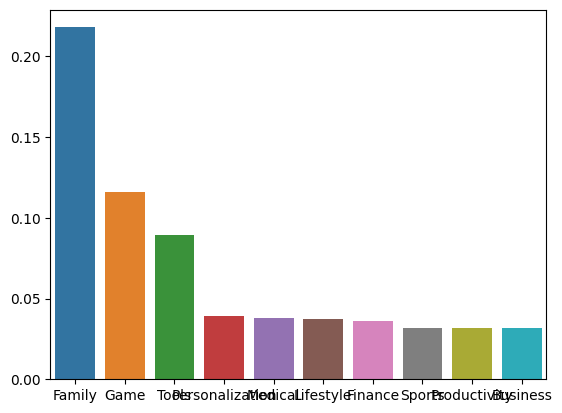

In [129]:
bar = sns.barplot(x=top10_proportion.index,
             y=top10_proportion.values)

In [ ]:
category_installs = data_cleaned.groupby('Category').agg({'Installs':pd.Series.sum})
category_installs.sort_values('Installs', ascending=True, inplace=True)

In [ ]:
h_bar = px.bar(x=category_installs.Installs, y=category_installs.index, orientation='h', title='Category Popularity by Number of Installs')
h_bar.update_layout(xaxis_title='Installs', yaxis_title='Category')
h_bar.show()

### Downloads vs. Competition

In [ ]:
category_info = data_cleaned.groupby('Category').agg({'App':pd.Series.count, 'Installs':pd.Series.sum})
category_info.sort_values('Installs', ascending=False).head()

,App,Installs
Category,,
GAME,910,13858762717
COMMUNICATION,257,11039241530
TOOLS,719,8099724500
PRODUCTIVITY,301,5788070180
SOCIAL,203,5487841475


In [ ]:
scatter = px.scatter(category_info, # data
                    x='App', # column name
                    y='Installs',
                    title='Concentration of Categories',
                    size='App',
                    hover_name=category_info.index,
                    color='Installs')

scatter.update_layout(xaxis_title="Number of Apps (Lower=More Concentrated)",
                      yaxis_title="Installs",
                      yaxis=dict(type='log'))

scatter.show()

# Furthur Dividing the Genres

**Genres**: How many different types of genres are there? Can an app belong to more than one genre? Use `.stack()` and `.split()` along with `.value_counts()` to see how many apps in level 2 genres.

In [ ]:
# Split the strings on the semi-colon and then .stack them.
stack = data_cleaned.Genres.str.split(';', expand=True).stack()
print(f'We now have a single column with shape: {stack.shape}')
num_genres = stack.value_counts()
print(f'Number of genres: {len(num_genres)}')

We now have a single column with shape: (7362,)
Number of genres: 53


In [ ]:
bar = px.bar(x = num_genres.index[:15],
             y = num_genres.values[:15],
             title='Top Genres',
             hover_name=num_genres.index[:15],
             color=num_genres.values[:15],
             color_continuous_scale='Agsunset')

bar.update_layout(xaxis_title='Genre',yaxis_title='Number of Apps',coloraxis_showscale=False)
bar.show()

# What Are The Differences Between Paid and Free Apps?

Paid apps cost \$14.05 on average. They are also rated slighly higher than free apps on average. However, they have far less popularity, as their reviews and installs account for

Free apps dominate the Play Store in each category. Beauty, Comics, Events, and House/Home apps have no paid apps.

In [ ]:
data_cleaned.groupby('Type')[['Price', 'Rating', 'Reviews', 'Installs']].mean(numeric_only=True)

,Price,Rating,Reviews,Installs
Type,,,,
Free,0.00,4.15,"156,151.80","4,829,307.88"
Paid,15.24,4.24,"6,867.77","78,223.26"


In [128]:
#free_vs_paid = data_cleaned.groupby(["Category", "Type"], as_index=False).agg({'App': pd.Series.count})
free_vs_paid = data_cleaned.groupby(['Category', 'Type'])[['App']].count()
free_vs_paid

App
Category          Type      
Art & Design      Free    56
                  Paid     3
Auto & Vehicles   Free    63
Beauty            Free    37
Books & Reference Free   134
                  Paid     7
Business          Free   213
                  Paid     8
Comics            Free    47
Communication     Free   171
                  Paid    18
Dating            Free   120
                  Paid     2
Education         Free    81
                  Paid     4
Entertainment     Free    60
                  Paid     1
Events            Free    38
Family            Free  1389
                  Paid   140
Finance           Free   245
                  Paid     7
Food & Drink      Free    71
                  Paid     1
Game              Free   740
                  Paid    74
Health & Fitness  Free   183
                  Paid     8
House & Home      Free    50
Libraries & Demo  Free    61
Lifestyle         Free   253
                  Paid    11
Maps & Navigation Free    90
                  Paid     4
Medical           Free   212
                  Paid    54
News & Magazines  Free   152
                  Paid     2
Parenting         Free    43
                  Paid     1
Personalization   Free   214
                  Paid    62
Photography       Free   191
                  Paid    13
Productivity      Free   209
                  Paid    14
Shopping          Free   144
                  Paid     2
Social            Free   154
                  Paid     2
Sports            Free   203
                  Paid    20
Tools             Free   571
                  Paid    55
Travel & Local    Free   135
                  Paid     6
Video Players     Free   112
                  Paid     1
Weather           Free    44
                  Paid     6

In [ ]:
g_bar = px.bar(data_cleaned, x='Category', y='App', title='Free vs. Paid Apps by Category', color='Type', barmode='group')
g_bar.update_layout(xaxis_title='Category', yaxis_title='Number of Apps', xaxis={'categoryorder':'total descending'}, yaxis=dict(type='log'))
g_bar.show()

# Revenue by App Category


In [ ]:
paid_apps = data_cleaned[data_cleaned['Type'] == 'Paid']
box = px.box(data_cleaned,
             x='Category',
             y='Revenue_Estimate',
             title='How Much Can Paid Apps Earn?')

box.update_layout(xaxis_title='Category',
                  yaxis_title='Paid App Ballpark Revenue',
                  xaxis={'categoryorder':'min ascending'},
                  yaxis=dict(type='log'))
box.show()

ValueError: ignored

# How Much Do Developers Charge?

While the overall median price for an app is 2.99, Paid App Median Price vs. Paid App Price Distribution per Category, to show which category is about the median paid app price.

In [ ]:
paid_apps.Price.median()

NameError: ignored

In [ ]:
box = px.box(df_paid_apps,
             x='Category',
             y="Price",
             title='Price per Category')

box.update_layout(xaxis_title='Category',
                  yaxis_title='Paid App Price',
                  xaxis={'categoryorder':'max descending'},
                  yaxis=dict(type='log'))
box.show()

# Visualing Content Ratings

Apps intended for users of all ages are the most popular in the Play Store. This is expected, given that the number of potential users is higher.

`Everyone 10+` is

In [ ]:
ratings = data_cleaned.Content_Rating.value_counts()
ratings.head()

Everyone           5682
Teen                779
Mature 17+          304
Everyone 10+        259
Adults only 18+       2
Name: Content_Rating, dtype: int64

In [ ]:
fig = px.pie(labels=ratings.index, values=ratings.values, names=ratings.index, title='Content Rating', hole=0.6)
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:137: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return args["labels"][column]


#End Notebook